# Predcition of Hospital Admission Related to Upper Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to ipper respiratory tract infection (URTI). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_date_'+str(i), 'urti_ab_date_'+str(i), 'urti_ab_type_'+str(i),
                   'incdt_urti_date_'+str(i), 'admitted_urti_date_'+str(i), 'sgss_gp_cov_urti_date_'+str(i)]]
    
    #drop rows with no urti reord
    datum = datum[datum['urti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_i
    datum = datum[datum['sgss_gp_cov_urti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_date_'+str(i): 'urti_date', 'urti_ab_date_'+str(i): 'urti_ab_date', 
                           'urti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_date_'+str(i): 'incdt_urti_date', 'incdt_urti_type_'+str(i): 'incdt_urti_type',
                           'admitted_urti_date_'+str(i): 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_'+str(i): 'sgss_gp_cov_urti_date'},
                inplace=True)
    
    return datum

In [5]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [6]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs): #data_urti_incdt, data_urti_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_urti_admitted',
            event_col='event_urti_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_urti_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #save and print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [9]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [10]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [11]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')

In [12]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [13]:
#process 20 urtis and concatenate them 
data_urti_1 = proc_infec_data(data,1)
data_urti_2 = proc_infec_data(data,2)
data_urti_3 = proc_infec_data(data,3)
data_urti_4 = proc_infec_data(data,4)
data_urti_5 = proc_infec_data(data,5)
data_urti_6 = proc_infec_data(data,6)
data_urti_7 = proc_infec_data(data,7)
data_urti_8 = proc_infec_data(data,8)
data_urti_9 = proc_infec_data(data,9)
data_urti_10 = proc_infec_data(data,10)
data_urti_11 = proc_infec_data(data,11)
data_urti_12 = proc_infec_data(data,12)
data_urti_13 = proc_infec_data(data,13)
data_urti_14 = proc_infec_data(data,14)
data_urti_15 = proc_infec_data(data,15)
data_urti_16 = proc_infec_data(data,16)
data_urti_17 = proc_infec_data(data,17)
data_urti_18 = proc_infec_data(data,18)
data_urti_19 = proc_infec_data(data,19)
data_urti_20 = proc_infec_data(data,20)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4, data_urti_5, data_urti_6, data_urti_7, data_urti_8, data_urti_9, data_urti_10, data_urti_11, data_urti_12, data_urti_13, data_urti_14, data_urti_15, data_urti_16, data_urti_17, data_urti_18, data_urti_19, data_urti_20])
data_urti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [14]:
##add variable season
#convert data types
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['urti_date'] 
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti with today's date in year and month
data_urti = data_urti[data_urti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti = data_urti[data_urti['date'] != last_1_month_date_y_m]
data_urti = data_urti[data_urti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti['season'] = np.select(conditions, choices, default='winter')

In [15]:
#add variable time period
data_urti.loc[(data_urti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti.loc[((data_urti['date'] >= '2020-05') & (data_urti['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_urti.loc[(data_urti['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

In [16]:
data_urti['date'].max()

'2023-03'

#### event and duration

In [17]:
#scenario 1
#not hosped (nothing happened)
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0

In [18]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]

In [19]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0

#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [20]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30

#give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [21]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [22]:
#drop anybody with age less than 18 or 0!
data_urti = data_urti[~(data_urti['age'] < 18)] 
data_urti['age'][data_urti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti = data_urti[data_urti['age_cat'] != '0-4']
data_urti = data_urti[data_urti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti['bmi'][data_urti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti['bmi'] = data_urti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti['antibacterial_brit'][data_urti['antibacterial_brit'] < 0] = np.nan

In [23]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"smoking": dict_smoking})

In [24]:
#drop rows with missing region
if ('region' in data_urti.columns) and (data_urti['region'].isnull().sum() > 0):
   data_urti = data_urti[data_urti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti.columns) and (data_urti['antibacterial_brit'].isnull().sum() > 0):
    data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti.columns) and (data_urti['ethnicity'].isnull().sum() > 0):
    data_urti['ethnicity'] = data_urti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_urti.columns) and (data_urti['smoking'].isnull().sum() > 0):
    data_urti['smoking'] = data_urti['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti.columns) and (data_urti['imd'].isnull().sum() > 0):
    data_urti['imd'] = data_urti['imd'].fillna(0)

In [25]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti['bmi_cat'] = 5

for idx, x in enumerate(data_urti['bmi_cat']):
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 30:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 25) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 30):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 18.5) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 25):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 18.5:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti.columns) and (data_urti['bmi_cat'].isnull().sum() > 0):
    data_urti['bmi_cat'] = data_urti['bmi_cat'].fillna(0)

In [26]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti['ab_type_cat'] = np.where(data_urti['ab_type'].isin(ab_series[mask].index),'other',data_urti['ab_type'])
#assign no to non ab users
data_urti.loc[data_urti['urti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti['ab_type_cat'] = data_urti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [27]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"ethnicity": dict_ethnicity})
data_urti = data_urti.replace({"smoking": dict_smoking})
data_urti = data_urti.replace({"imd": dict_imd})
data_urti = data_urti.replace({"bmi_cat": dict_bmi})
data_urti = data_urti.replace({"flu_vaccine": dict_flu})
data_urti = data_urti.replace({"region": dict_region})
data_urti = data_urti.replace({"age_cat": dict_age})
data_urti = data_urti.replace({"ab_type_cat": dict_ab_type})

In [28]:
data_urti.ethnicity.value_counts('NA')

white      0.602301
unknown    0.249627
asian      0.074485
other      0.073587
Name: ethnicity, dtype: float64

In [29]:
data_urti.smoking.value_counts('NA')

unknown         0.415179
smoker          0.390079
never_smoked    0.129308
ex_smoker       0.065434
Name: smoking_status, dtype: float64

In [30]:
data_urti.bmi_cat.value_counts('NA')

obese             0.517839
unknown           0.255165
overweight        0.111655
healthy_weight    0.082543
underweight       0.032798
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [31]:
#categorise CCI
data_urti['CCI_cat'] = pd.cut(data_urti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti['antibacterial_brit'].clip(0, data_urti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

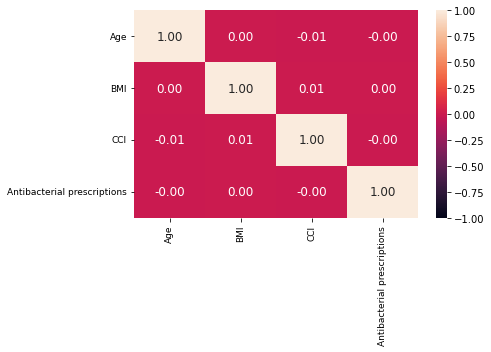

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [33]:
data_urti = data_urti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'urti_ab_date', 'ab_type_cat', 'incdt_urti_date', 'date', 'period',
                                   'event_urti_admitted', 'duration_urti_admitted'
                                    ]]

In [34]:
#switch variable urti_ab_date into a binary variable
data_urti[['ab_binary']] = data_urti[['urti_ab_date']].where(data_urti[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_urti_incdt = data_urti[data_urti['incdt_urti_date'] == 0]
data_urti_prevl = data_urti[data_urti['incdt_urti_date'] == 1]

#no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti_incdt[data_urti_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti_incdt[data_urti_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti_prevl[data_urti_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti_prevl[data_urti_prevl['ab_binary'] == 1]

In [35]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_urti_incdt_prepandemic = data_urti_incdt[data_urti_incdt['period'] == 'prepandemic']
data_urti_incdt_during_pandemic = data_urti_incdt[(data_urti_incdt['period'] == 'during_pandemic')]
data_urti_incdt_post_2nd_lockdown = data_urti_incdt[data_urti_incdt['period'] == 'post_2nd_lockdown']
data_urti_prevl_prepandemic = data_urti_prevl[data_urti_prevl['period'] == 'prepandemic']
data_urti_prevl_during_pandemic = data_urti_prevl[(data_urti_prevl['period'] == 'during_pandemic')]
data_urti_prevl_post_2nd_lockdown = data_urti_prevl[data_urti_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_urti_no_abs_incdt_prepandemic = data_urti_incdt_prepandemic[data_urti_incdt_prepandemic['ab_binary'] == 0]
data_urti_no_abs_incdt_during_pandemic = data_urti_incdt_during_pandemic[data_urti_incdt_during_pandemic['ab_binary'] == 0]
data_urti_no_abs_incdt_post_2nd_lockdown = data_urti_incdt_post_2nd_lockdown[data_urti_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_urti_no_abs_prevl_prepandemic = data_urti_prevl_prepandemic[data_urti_prevl_prepandemic['ab_binary'] == 0]
data_urti_no_abs_prevl_during_pandemic = data_urti_prevl_during_pandemic[data_urti_prevl_during_pandemic['ab_binary'] == 0]
data_urti_no_abs_prevl_post_2nd_lockdown = data_urti_prevl_post_2nd_lockdown[data_urti_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [36]:
#store data for plotting hosp admission counts and percentages
%store data_urti
# save data
data_urti.to_csv('../output/hospitalisation_prediction_urti/data_urti.csv')

Stored 'data_cough' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [ ]:
#make summary tables
make_summary_table('urti', 'no_abs_incdt', data_urti_no_abs_incdt)
make_summary_table('urti', 'abs_incdt', data_urti_abs_incdt)
make_summary_table('urti', 'no_abs_prevl', data_urti_no_abs_prevl)
make_summary_table('urti', 'abs_prevl', data_urti_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 108256 total observations, 107580 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 108256
number of events observed = 676
   partial log-likelihood = -7822.56
         time fit was run = 2023-06-28 14:21:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.11            -0.18             0.27                 0.83                 1.31
CCI_cat[T.medium]                0.02       1.02       0.13            -0.23             0.27                 0.79                 1.31
CCI_cat[T.high]                  0.03       1.03       0.15            -0.27             0.33                 0.76                 1.39
CCI_cat[T.very_high]             0.01       1.01       0.13            -0.25             0.28                 0.78                 1.32
age_cat[T.25_34]                -0.25       0.78       0.14            -0.53             0.03                 0.59                 1.03
age_cat[T.35_44]                -0.07       0.93       0.14            -0.34             0.19                 0.71                 1.22
age_cat[T.45_54]                -0.11       0.90       0.14            -0.38             0.16                 0.68                 1.17
age_cat[T.55_64]                -0.18       0.83       0.14            -0.46             0.09                 0.63                 1.09
age_cat[T.65_74]                -0.21       0.81       0.14            -0.49             0.06                 0.61                 1.07
age_cat[T.75_more]              -0.22       0.80       0.14            -0.50             0.06                 0.61                 1.06
antibacterial_brit               0.01       1.01       0.03            -0.04             0.07                 0.96                 1.07
bmi_cat[T.obese]                 0.05       1.05       0.15            -0.24             0.34                 0.79                 1.40
bmi_cat[T.overweight]            0.07       1.07       0.18            -0.28             0.41                 0.76                 1.51
bmi_cat[T.underweight]          -0.12       0.88       0.27            -0.65             0.40                 0.52                 1.49
bmi_cat[T.unknown]               0.03       1.03       0.16            -0.27             0.34                 0.76                 1.40
ethnicity[T.other]               0.07       1.07       0.20            -0.32             0.46                 0.72                 1.59
ethnicity[T.unknown]             0.00       1.00       0.16            -0.32             0.32                 0.73                 1.38
ethnicity[T.white]               0.06       1.06       0.15            -0.24             0.36                 0.79                 1.43
flu_vaccine[T.yes]              -0.13       0.88       0.13            -0.39             0.14                 0.68                 1.15
imd[T.medium]                   -0.05       0.95       0.13            -0.30             0.20                 0.74                 1.22
imd[T.unaffluent]               -0.06       0.94       0.13            -0.31             0.19                 0.74                 1.21
imd[T.unknown]                   0.20       1.22       0.18            -0.16             0.55                 0.85                 1.74
imd[T.very_affluent]             0.11       1.12       0.12            -0.12             0.35                 0.88                 1.42
imd[T.very_unaffluent]          -0.04       0.96       0.13            -0.29             0.21                 0.75                 1.23
region[T.east_midlands]          0.01       1.01       0.17    

13048


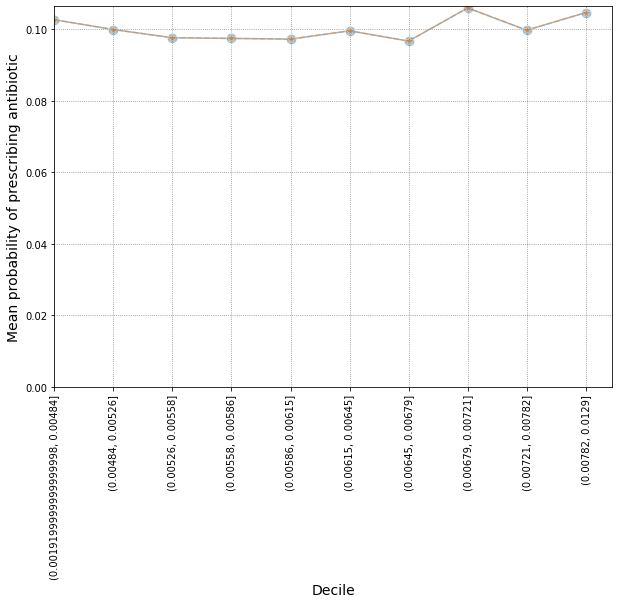


AUROC of LR for deciles with development and validation data: 0.51130 and 0.50402
AUROC of RF for deciles with development and validation data: 0.51910 and 0.50443
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0019199999999999998, 0.00484]  0.114107  0.107410  0.121222
bins_(0.00484, 0.00526]                0.115031  0.108316  0.122163
bins_(0.00526, 0.00558]                0.107034  0.100587  0.113896
bins_(0.00558, 0.00586]                0.105767  0.099362  0.112585
bins_(0.00586, 0.00615]                0.106691  0.100244  0.113554
bins_(0.00615, 0.00645]                0.109630  0.103034  0.116648
bins_(0.00645, 0.00679]                0.106889  0.100411  0.113786
bins_(0.00679, 0.00721]                0.116986  0.110097  0.124305
bins_(0.00721, 0.00782]                0.109333  0.102719  0.116373
bins_(0.00782, 0.0129]                 0.114950  0.108076  0.122261
antibacterial_brit                     1.009414  0.996144  1.022861



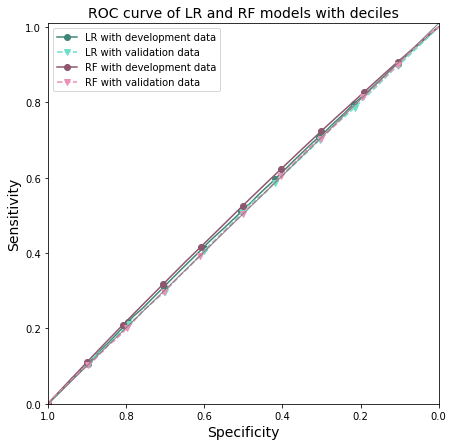

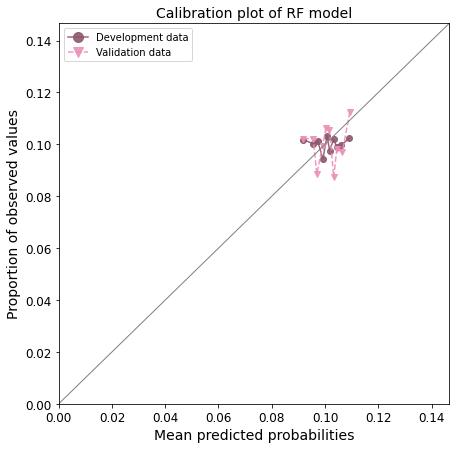

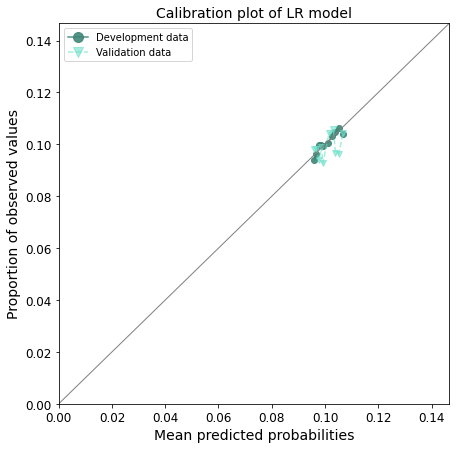


AUROC of LR for risk factors with development and validation data: 0.51519 and 0.49870
AUROC of RF for risk factors with development and validation data: 0.62089 and 0.49387
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.911344  0.000000       inf
age_cat_25_34                0.887250  0.000000       inf
age_cat_35_44                0.905644  0.000000       inf
age_cat_45_54                0.851697  0.000000       inf
age_cat_55_64                0.896806  0.000000       inf
age_cat_65_74                0.859040  0.000000       inf
age_cat_75_more              0.882932  0.000000       inf
sex_female                   0.654307       NaN       NaN
sex_male                     0.648378  0.000000       inf
CCI_cat_high                 0.845237  0.000000       inf
CCI_cat_low                  0.818647  0.000000       inf
CCI_cat_medium               0.869724  0.000000       inf
CCI_cat_very_high            0.813798  0.000000      

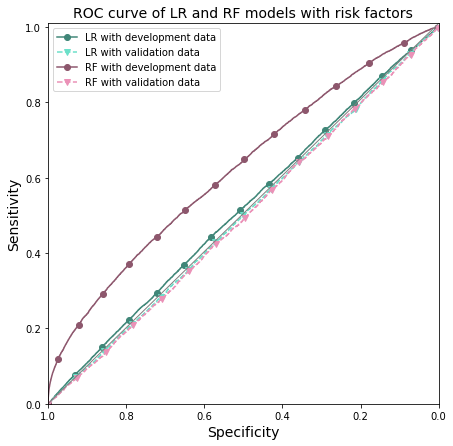

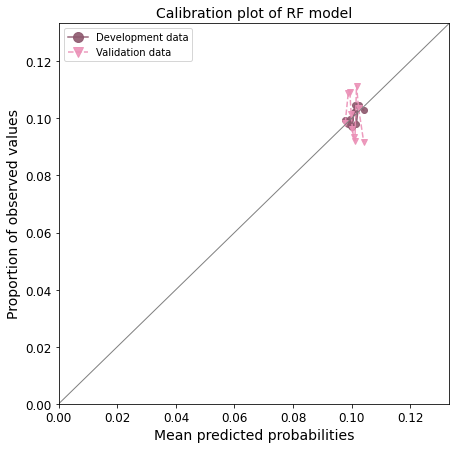

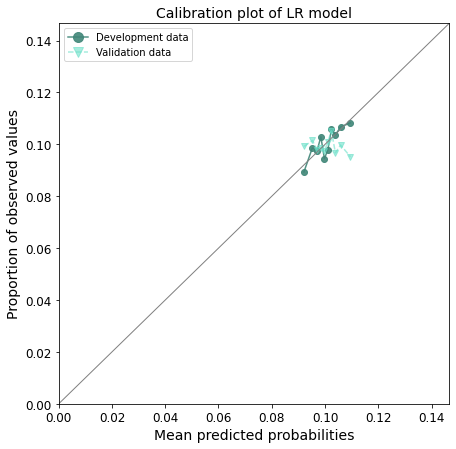

In [37]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt, prob_pred_urti_no_abs_incdt_bin = cox_build('urti', 'incdt', data_urti_incdt, data_urti_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models with deciles as predictors
    prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('urti', 'incdt_deciles', prob_pred_urti_no_abs_incdt)
    #calibration plots of rf and lr with deciles
    calibration_rf_lr('urti', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

try:
    #make summary table of deciles
    make_summary_table_deciles('urti', 'incdt', prob_pred_enc_lr_rf_incdt)
except:
    print("error_3: summary table of deciles failed.")

try:
    #build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('urti', 'incdt_riskfactors', prob_pred_urti_no_abs_incdt)
    #calibration plots of rf and lr with risk factors
    calibration_rf_lr('urti', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)
except:
    print("error_4: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 11945 total observations, 11860 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 11945
number of events observed = 85
   partial log-likelihood = -783.93
         time fit was run = 2023-06-28 14:23:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.79       0.31            -0.84             0.37                 0.43                 1.44
CCI_cat[T.medium]               -0.23       0.79       0.34            -0.90             0.44                 0.40                 1.56
CCI_cat[T.high]                 -0.27       0.76       0.43            -1.11             0.57                 0.33                 1.77
CCI_cat[T.very_high]            -0.15       0.86       0.36            -0.84             0.55                 0.43                 1.73
age_cat[T.25_34]                -0.65       0.52       0.44            -1.51             0.21                 0.22                 1.23
age_cat[T.35_44]                -0.34       0.71       0.40            -1.12             0.44                 0.33                 1.55
age_cat[T.45_54]                -0.33       0.72       0.40            -1.11             0.45                 0.33                 1.57
age_cat[T.55_64]                 0.07       1.08       0.36            -0.63             0.78                 0.53                 2.18
age_cat[T.65_74]                -0.32       0.73       0.40            -1.10             0.46                 0.33                 1.59
age_cat[T.75_more]              -0.19       0.83       0.38            -0.94             0.55                 0.39                 1.74
antibacterial_brit              -0.10       0.90       0.08            -0.26             0.06                 0.77                 1.06
bmi_cat[T.obese]                -0.29       0.75       0.37            -1.01             0.43                 0.36                 1.54
bmi_cat[T.overweight]           -0.31       0.73       0.47            -1.24             0.62                 0.29                 1.85
bmi_cat[T.underweight]          -1.28       0.28       1.05            -3.35             0.79                 0.04                 2.20
bmi_cat[T.unknown]              -0.20       0.82       0.39            -0.98             0.57                 0.38                 1.76
ethnicity[T.other]              -0.24       0.79       0.76            -1.73             1.26                 0.18                 3.54
ethnicity[T.unknown]             0.48       1.61       0.55            -0.59             1.55                 0.55                 4.71
ethnicity[T.white]               0.61       1.84       0.52            -0.40             1.63                 0.67                 5.09
flu_vaccine[T.yes]              -0.41       0.67       0.42            -1.24             0.42                 0.29                 1.53
imd[T.medium]                   -0.66       0.52       0.39            -1.43             0.11                 0.24                 1.11
imd[T.unaffluent]               -0.24       0.79       0.34            -0.90             0.43                 0.41                 1.54
imd[T.unknown]                  -0.46       0.63       0.62            -1.68             0.76                 0.19                 2.14
imd[T.very_affluent]            -0.08       0.93       0.33            -0.72             0.57                 0.49                 1.77
imd[T.very_unaffluent]          -0.02       0.98       0.33            -0.66             0.61                 0.52                 1.85
region[T.east_midlands]         -0.15       0.86       0.52         

13059


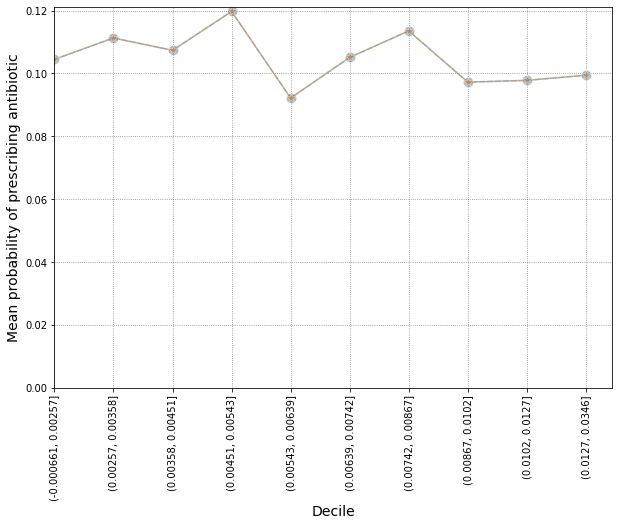


AUROC of LR for deciles with development and validation data: 0.52989 and 0.50530
AUROC of RF for deciles with development and validation data: 0.55582 and 0.48786
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.000661, 0.00257]  0.115477  0.095853  0.139117
bins_(0.00257, 0.00358]    0.122004  0.101818  0.146191
bins_(0.00358, 0.00451]    0.108846  0.090073  0.131532
bins_(0.00451, 0.00543]    0.125855  0.105028  0.150813
bins_(0.00543, 0.00639]    0.096061  0.079047  0.116737
bins_(0.00639, 0.00742]    0.120142  0.100579  0.143510
bins_(0.00742, 0.00867]    0.129678  0.109226  0.153959
bins_(0.00867, 0.0102]     0.095596  0.078853  0.115895
bins_(0.0102, 0.0127]      0.108098  0.090037  0.129781
bins_(0.0127, 0.0346]      0.116994  0.098172  0.139423
antibacterial_brit         1.024592  0.984618  1.066190

RF feature importance:
                             rf_coef
antibacterial_brit         0.588058
bins_(0.00867, 0.0102]     0.056435
bins_(0.0054

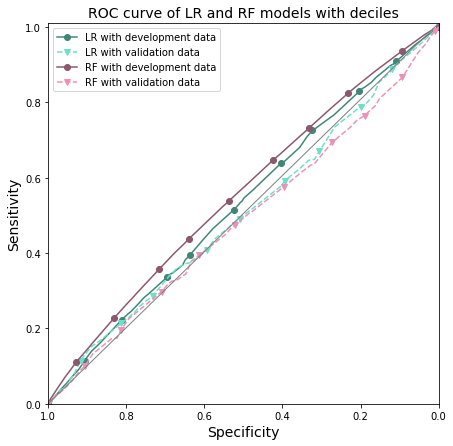

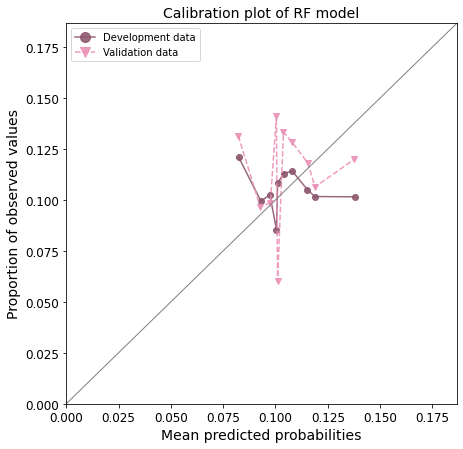

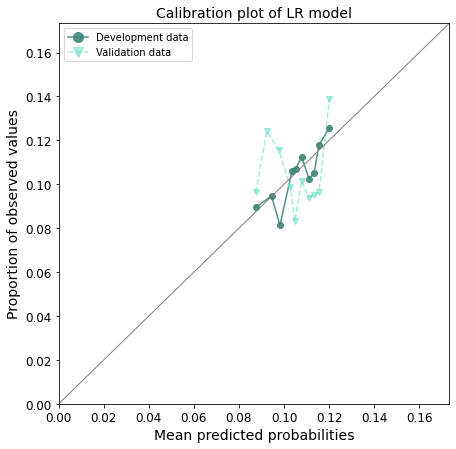


AUROC of LR for risk factors with development and validation data: 0.55065 and 0.47452
AUROC of RF for risk factors with development and validation data: 0.78123 and 0.48343
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.897081  0.000000       inf
age_cat_25_34                0.809946       NaN       NaN
age_cat_35_44                0.937428       NaN       NaN
age_cat_45_54                0.905848       NaN       NaN
age_cat_55_64                0.889503  0.000000       inf
age_cat_65_74                0.928389  0.000000       inf
age_cat_75_more              0.835748       NaN       NaN
sex_female                   0.677407  0.000000       inf
sex_male                     0.628614  0.000000       inf
CCI_cat_high                 0.971778  0.000000       inf
CCI_cat_low                  0.836058  0.000000       inf
CCI_cat_medium               0.810823  0.000000       inf
CCI_cat_very_high            0.850313  0.000000      

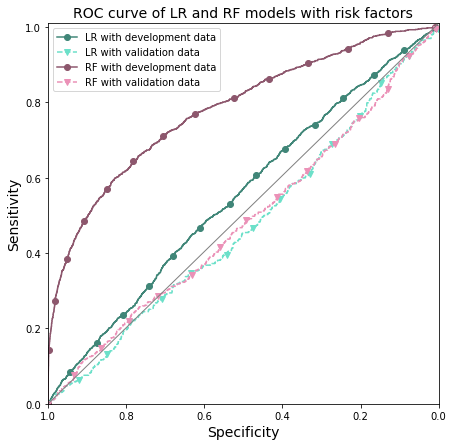

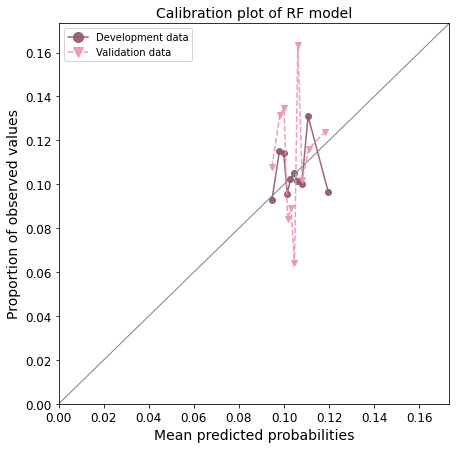

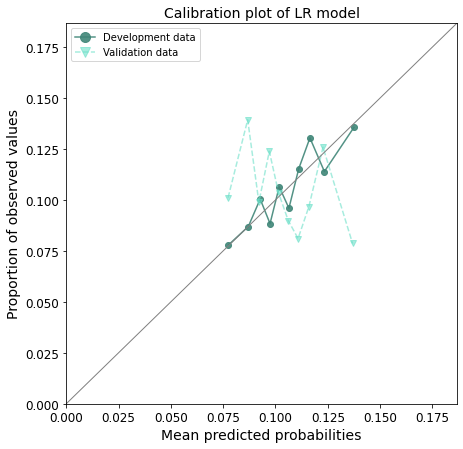

In [38]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl, prob_pred_urti_no_abs_prevl_bin = cox_build('urti', 'prevl', data_urti_prevl, data_urti_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models with deciles as predictors
    prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('urti', 'prevl_deciles', prob_pred_urti_no_abs_prevl)
    #calibration plots of rf and lr with deciles
    calibration_rf_lr('urti', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

try:
    #make summary table of deciles
    make_summary_table_deciles('urti', 'prevl', prob_pred_enc_lr_rf_prevl)
except:
    print("error_3: summary table of deciles failed.")

try:
    #build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('urti', 'prevl_riskfactors', prob_pred_urti_no_abs_prevl)
    #calibration plots of rf and lr with risk factors
    calibration_rf_lr('urti', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)
except:
    print("error_4: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28791 total observations, 28619 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 28791
number of events observed = 172
   partial log-likelihood = -1747.25
         time fit was run = 2023-06-28 14:24:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.23            -0.50             0.42                 0.61                 1.52
CCI_cat[T.medium]                0.09       1.10       0.25            -0.40             0.59                 0.67                 1.80
CCI_cat[T.high]                  0.02       1.02       0.31            -0.59             0.63                 0.56                 1.87
CCI_cat[T.very_high]             0.23       1.26       0.26            -0.27             0.74                 0.76                 2.09
age_cat[T.25_34]                -0.47       0.62       0.27            -0.99             0.05                 0.37                 1.05
age_cat[T.35_44]                -0.52       0.60       0.27            -1.04             0.01                 0.35                 1.01
age_cat[T.45_54]                -0.59       0.56       0.27            -1.12            -0.05                 0.33                 0.95
age_cat[T.55_64]                -0.63       0.53       0.28            -1.18            -0.09                 0.31                 0.91
age_cat[T.65_74]                -0.37       0.69       0.26            -0.88             0.13                 0.41                 1.14
age_cat[T.75_more]              -0.43       0.65       0.26            -0.94             0.09                 0.39                 1.09
antibacterial_brit              -0.00       1.00       0.05            -0.11             0.10                 0.90                 1.11
bmi_cat[T.obese]                -0.03       0.97       0.27            -0.56             0.50                 0.57                 1.64
bmi_cat[T.overweight]           -0.11       0.89       0.34            -0.78             0.55                 0.46                 1.74
bmi_cat[T.underweight]          -0.06       0.94       0.48            -1.00             0.88                 0.37                 2.41
bmi_cat[T.unknown]              -0.34       0.71       0.30            -0.93             0.25                 0.39                 1.29
ethnicity[T.other]               0.38       1.46       0.43            -0.47             1.23                 0.62                 3.42
ethnicity[T.unknown]             0.38       1.46       0.37            -0.34             1.09                 0.71                 2.98
ethnicity[T.white]               0.40       1.49       0.35            -0.28             1.08                 0.75                 2.94
flu_vaccine[T.yes]              -0.25       0.78       0.28            -0.80             0.30                 0.45                 1.34
imd[T.medium]                    0.23       1.26       0.26            -0.29             0.74                 0.75                 2.10
imd[T.unaffluent]                0.06       1.06       0.27            -0.48             0.60                 0.62                 1.82
imd[T.unknown]                   0.46       1.58       0.37            -0.27             1.19                 0.76                 3.27
imd[T.very_affluent]             0.48       1.61       0.25            -0.01             0.97                 0.99                 2.63
imd[T.very_unaffluent]           0.22       1.25       0.26            -0.30             0.73                 0.74                 2.08
region[T.east_midlands]         -0.21       0.81       0.37       

13044


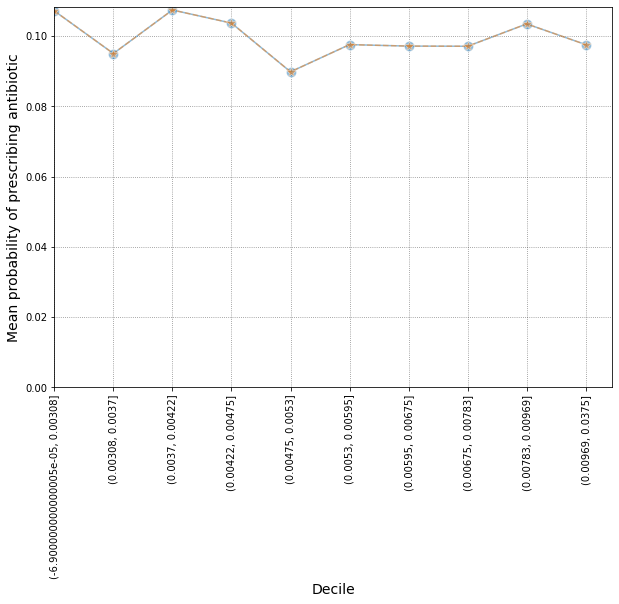


AUROC of LR for deciles with development and validation data: 0.52061 and 0.49581
AUROC of RF for deciles with development and validation data: 0.53878 and 0.51498
LR coefficients:
                                               OR  Lower CI  Upper CI
bins_(-6.900000000000005e-05, 0.00308]  0.116182  0.103218  0.130776
bins_(0.00308, 0.0037]                  0.107227  0.094958  0.121081
bins_(0.0037, 0.00422]                  0.121834  0.108471  0.136844
bins_(0.00422, 0.00475]                 0.123531  0.110126  0.138568
bins_(0.00475, 0.0053]                  0.094768  0.083486  0.107574
bins_(0.0053, 0.00595]                  0.109452  0.097030  0.123463
bins_(0.00595, 0.00675]                 0.106784  0.094634  0.120494
bins_(0.00675, 0.00783]                 0.105481  0.093405  0.119118
bins_(0.00783, 0.00969]                 0.112348  0.099669  0.126641
bins_(0.00969, 0.0375]                  0.104914  0.092889  0.118495
antibacterial_brit                      1.003089  0.977586

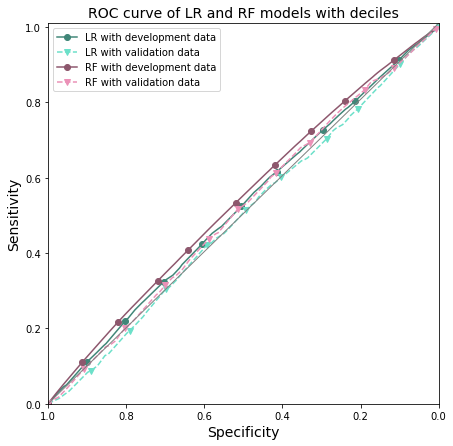

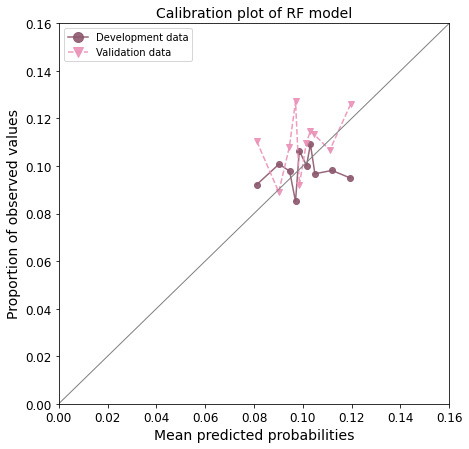

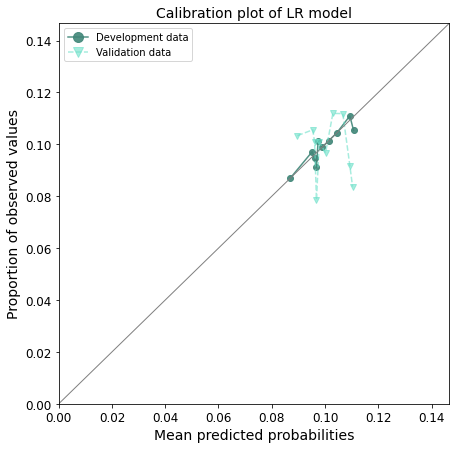

In [39]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt_prepandemic, prob_pred_urti_no_abs_incdt_prepandemic_bin = cox_build('urti', 'incdt_prepandemic', data_urti_incdt_prepandemic, data_urti_no_abs_incdt_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('urti', 'incdt_prepandemic_deciles', prob_pred_urti_no_abs_incdt_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

In [1]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt_during_pandemic, prob_pred_urti_no_abs_incdt_during_pandemic_bin = cox_build('urti', 'incdt_during_pandemic', data_urti_incdt_during_pandemic, data_urti_no_abs_incdt_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('urti', 'incdt_during_pandemic_deciles', prob_pred_urti_no_abs_incdt_during_pandemic)

    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 46485 total observations, 46151 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 46485
number of events observed = 334
   partial log-likelihood = -3573.60
         time fit was run = 2023-06-28 14:24:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.16            -0.29             0.36                 0.75                 1.43
CCI_cat[T.medium]                0.03       1.03       0.18            -0.32             0.39                 0.72                 1.48
CCI_cat[T.high]                  0.08       1.08       0.21            -0.34             0.50                 0.71                 1.64
CCI_cat[T.very_high]             0.08       1.09       0.19            -0.29             0.45                 0.75                 1.57
age_cat[T.25_34]                 0.06       1.06       0.22            -0.37             0.48                 0.69                 1.62
age_cat[T.35_44]                 0.29       1.34       0.21            -0.12             0.70                 0.89                 2.01
age_cat[T.45_54]                 0.31       1.36       0.21            -0.10             0.71                 0.91                 2.04
age_cat[T.55_64]                 0.09       1.09       0.22            -0.34             0.51                 0.71                 1.67
age_cat[T.65_74]                 0.19       1.20       0.21            -0.23             0.60                 0.80                 1.82
age_cat[T.75_more]               0.17       1.19       0.21            -0.25             0.59                 0.78                 1.81
antibacterial_brit              -0.02       0.98       0.04            -0.09             0.06                 0.91                 1.06
bmi_cat[T.obese]                 0.06       1.06       0.21            -0.36             0.48                 0.70                 1.61
bmi_cat[T.overweight]           -0.06       0.94       0.27            -0.58             0.46                 0.56                 1.58
bmi_cat[T.underweight]          -0.29       0.75       0.41            -1.08             0.51                 0.34                 1.66
bmi_cat[T.unknown]               0.23       1.26       0.22            -0.21             0.67                 0.81                 1.95
ethnicity[T.other]               0.16       1.17       0.28            -0.39             0.70                 0.68                 2.02
ethnicity[T.unknown]            -0.07       0.93       0.24            -0.53             0.39                 0.59                 1.48
ethnicity[T.white]               0.09       1.10       0.22            -0.33             0.52                 0.72                 1.68
flu_vaccine[T.yes]              -0.20       0.82       0.20            -0.59             0.18                 0.55                 1.20
imd[T.medium]                    0.03       1.03       0.18            -0.32             0.39                 0.72                 1.47
imd[T.unaffluent]                0.03       1.03       0.18            -0.32             0.39                 0.72                 1.47
imd[T.unknown]                   0.43       1.54       0.24            -0.04             0.91                 0.96                 2.48
imd[T.very_affluent]             0.03       1.03       0.18            -0.32             0.39                 0.73                 1.47
imd[T.very_unaffluent]          -0.01       0.99       0.18            -0.37             0.35                 0.69                 1.41
region[T.east_midlands]         -0.24       0.79       0.24       

13040


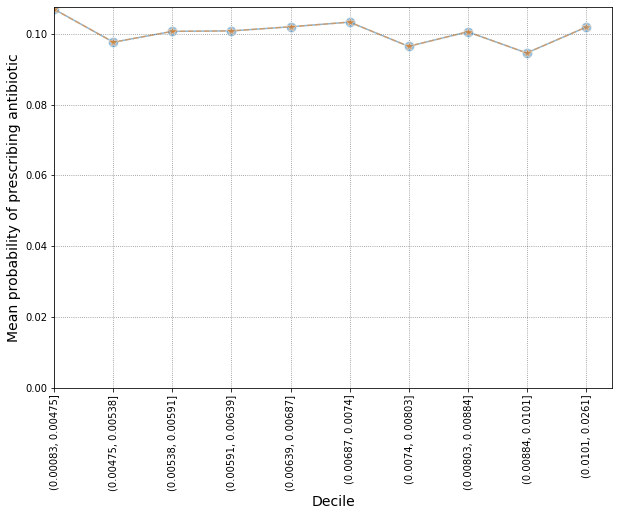


AUROC of LR for deciles with development and validation data: 0.51536 and 0.50626
AUROC of RF for deciles with development and validation data: 0.52647 and 0.50647
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00083, 0.00475]  0.113310  0.103119  0.124508
bins_(0.00475, 0.00538]  0.107756  0.097968  0.118523
bins_(0.00538, 0.00591]  0.106294  0.096625  0.116930
bins_(0.00591, 0.00639]  0.113135  0.103096  0.124151
bins_(0.00639, 0.00687]  0.111120  0.101236  0.121970
bins_(0.00687, 0.0074]   0.116166  0.105929  0.127391
bins_(0.0074, 0.00803]   0.103912  0.094433  0.114343
bins_(0.00803, 0.00884]  0.110714  0.100855  0.121537
bins_(0.00884, 0.0101]   0.099954  0.090698  0.110155
bins_(0.0101, 0.0261]    0.110921  0.101106  0.121689
antibacterial_brit       1.020661  1.000311  1.041426

RF feature importance:
                           rf_coef
antibacterial_brit       0.592341
bins_(0.00884, 0.0101]   0.063625
bins_(0.00687, 0.0074]   0.049588
bins_(0.

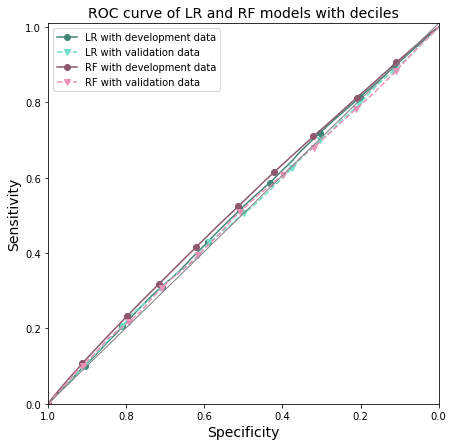

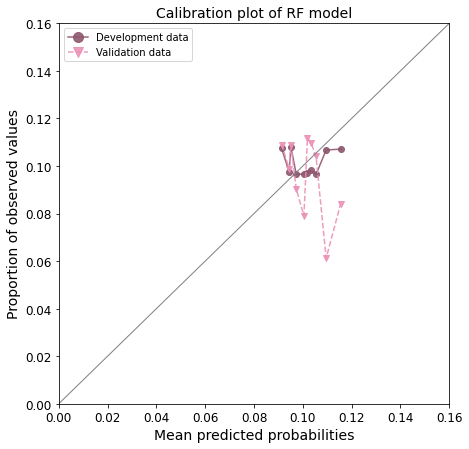

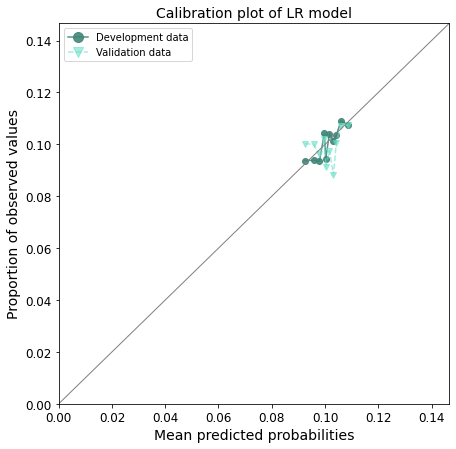

In [41]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_incdt_post_2nd_lockdown, prob_pred_urti_no_abs_incdt_post_2nd_lockdown_bin = cox_build('urti', 'incdt_post_2nd_lockdown', data_urti_incdt_post_2nd_lockdown, data_urti_no_abs_incdt_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('urti', 'incdt_post_2nd_lockdown_deciles', prob_pred_urti_no_abs_incdt_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

In [2]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl_prepandemic, prob_pred_urti_no_abs_prevl_prepandemic_bin = cox_build('urti', 'prevl_prepandemic', data_urti_prevl_prepandemic, data_urti_no_abs_prevl_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('urti', 'prevl_prepandemic_deciles', prob_pred_urti_no_abs_prevl_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

In [1]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl_during_pandemic, prob_pred_urti_no_abs_prevl_during_pandemic_bin = cox_build('urti', 'prevl_during_pandemic', data_urti_prevl_during_pandemic, data_urti_no_abs_prevl_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('urti', 'prevl_during_pandemic_deciles', prob_pred_urti_no_abs_prevl_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 5222 total observations, 5181 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 5222
number of events observed = 41
   partial log-likelihood = -338.95
         time fit was run = 2023-06-28 14:25:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.58       1.79       0.57            -0.53             1.69                 0.59                 5.44
CCI_cat[T.medium]                0.77       2.16       0.59            -0.39             1.93                 0.67                 6.90
CCI_cat[T.high]                  0.74       2.10       0.67            -0.58             2.06                 0.56                 7.85
CCI_cat[T.very_high]             0.72       2.05       0.61            -0.49             1.92                 0.62                 6.83
age_cat[T.25_34]                -0.60       0.55       0.63            -1.83             0.63                 0.16                 1.88
age_cat[T.35_44]                -0.43       0.65       0.59            -1.58             0.72                 0.21                 2.06
age_cat[T.45_54]                -0.62       0.54       0.63            -1.86             0.61                 0.16                 1.84
age_cat[T.55_64]                 0.09       1.10       0.52            -0.93             1.11                 0.39                 3.05
age_cat[T.65_74]                -0.07       0.94       0.54            -1.12             0.99                 0.33                 2.68
age_cat[T.75_more]              -0.21       0.81       0.56            -1.31             0.88                 0.27                 2.41
antibacterial_brit              -0.01       0.99       0.11            -0.22             0.21                 0.80                 1.24
bmi_cat[T.obese]                -0.13       0.88       0.55            -1.20             0.94                 0.30                 2.56
bmi_cat[T.overweight]           -0.25       0.78       0.71            -1.64             1.14                 0.19                 3.14
bmi_cat[T.underweight]          -0.42       0.66       1.12            -2.61             1.78                 0.07                 5.95
bmi_cat[T.unknown]              -0.21       0.81       0.59            -1.37             0.96                 0.25                 2.61
ethnicity[T.other]              -0.19       0.83       0.92            -1.99             1.61                 0.14                 5.00
ethnicity[T.unknown]             0.36       1.44       0.64            -0.90             1.62                 0.41                 5.07
ethnicity[T.white]               0.00       1.00       0.62            -1.21             1.21                 0.30                 3.35
flu_vaccine[T.yes]              -0.82       0.44       0.73            -2.24             0.61                 0.11                 1.84
imd[T.medium]                   -0.20       0.82       0.67            -1.52             1.12                 0.22                 3.05
imd[T.unaffluent]                0.64       1.90       0.55            -0.44             1.72                 0.65                 5.57
imd[T.unknown]                 -16.43       0.00    3297.25         -6478.91          6446.06                 0.00                  inf
imd[T.very_affluent]             0.77       2.17       0.54            -0.29             1.83                 0.75                 6.26
imd[T.very_unaffluent]           0.84       2.32       0.54            -0.22             1.90                 0.80                 6.71
region[T.east_midlands]         -0.30       0.74       0.77            

13055


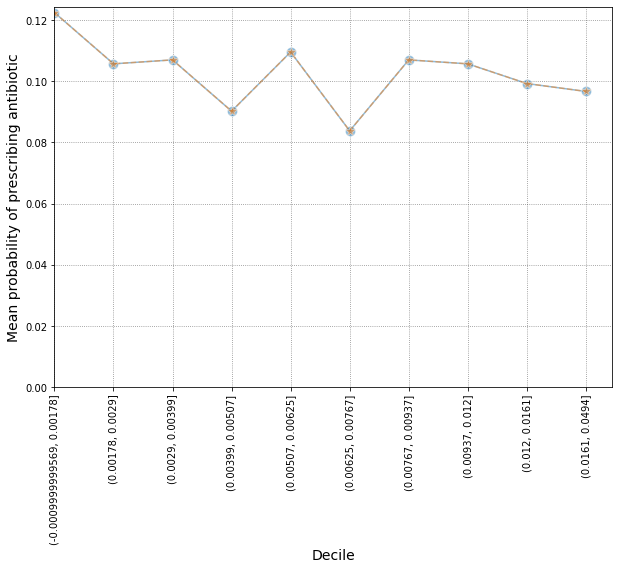


AUROC of LR for deciles with development and validation data: 0.54278 and 0.50521
AUROC of RF for deciles with development and validation data: 0.59309 and 0.48889
LR coefficients:
                                         OR  Lower CI  Upper CI
bins_(-0.0009999999569, 0.00178]  0.136441  0.105386  0.176649
bins_(0.00178, 0.0029]            0.110128  0.083272  0.145645
bins_(0.0029, 0.00399]            0.114150  0.086442  0.150740
bins_(0.00399, 0.00507]           0.089129  0.065983  0.120395
bins_(0.00507, 0.00625]           0.114489  0.087045  0.150587
bins_(0.00625, 0.00767]           0.081985  0.059983  0.112057
bins_(0.00767, 0.00937]           0.122454  0.093502  0.160370
bins_(0.00937, 0.012]             0.122054  0.093612  0.159138
bins_(0.012, 0.0161]              0.110012  0.083545  0.144864
bins_(0.0161, 0.0494]             0.096767  0.072668  0.128857
antibacterial_brit                1.039323  0.980068  1.102160

RF feature importance:
                                    r

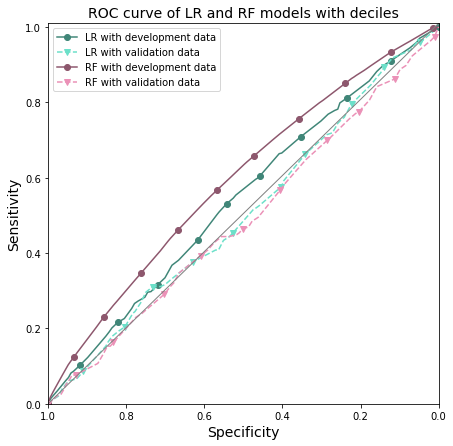

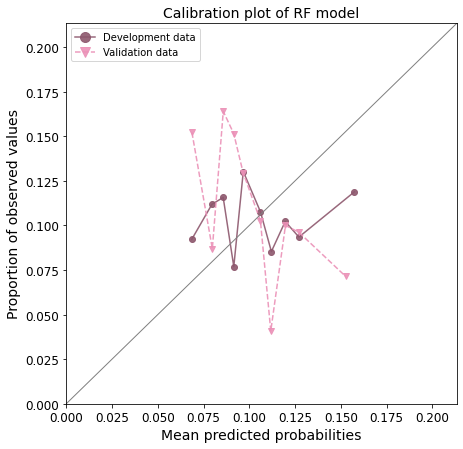

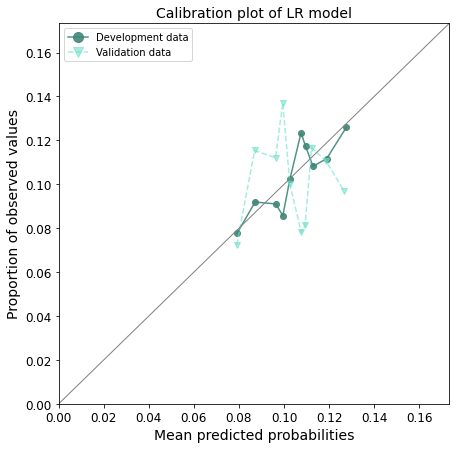

In [44]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_urti_no_abs_prevl_post_2nd_lockdown, prob_pred_urti_no_abs_prevl_post_2nd_lockdown_bin = cox_build('urti', 'prevl_post_2nd_lockdown', data_urti_prevl_post_2nd_lockdown, data_urti_no_abs_prevl_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('urti', 'prevl_post_2nd_lockdown_deciles', prob_pred_urti_no_abs_prevl_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('urti', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")